<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Business-Understanding" data-toc-modified-id="Business-Understanding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Business Understanding</a></span><ul class="toc-item"><li><span><a href="#Sources" data-toc-modified-id="Sources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sources</a></span></li><li><span><a href="#Data-Collection-Techniques" data-toc-modified-id="Data-Collection-Techniques-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Collection Techniques</a></span></li></ul></li><li><span><a href="#Data-cleaning-&amp;-Text-Pre-Processing" data-toc-modified-id="Data-cleaning-&amp;-Text-Pre-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data cleaning &amp; Text Pre-Processing</a></span><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Processing-Data" data-toc-modified-id="Processing-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Processing Data</a></span></li></ul></li><li><span><a href="#Data-Understanding" data-toc-modified-id="Data-Understanding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Understanding</a></span></li><li><span><a href="#Story-Telling" data-toc-modified-id="Story-Telling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Story Telling</a></span></li></ul></div>

##### Imports

In [490]:
# import python packages
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import os
from collections import defaultdict
import itertools
from isodate import parse_duration

from sklearn import preprocessing
import seaborn as sns
from scipy import stats

import numpy as np
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob

# Vader sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

from pattern.en import sentiment

# Business Understanding

 

The purpose of this project is to try and predict if a particular TV show will be either renewed or canceled.
This will be based on data collected and analyzed from IMDb and twitter. In particular, I will try to gauge the
shows popularity by:
* looking at the IMDb score and the number of users who voted
* analyzing sentiment of the reviews
* analyzing review scores
* analyzing the shows popularity by it twitter following


If successful, the real world applications of this could be:
* Help networks decide whether or not to renew or cancel a show
* Could help entertainment news agencies better predict a shows renewal\cancellation


The question I would like to answer are:
1. Does a strong twitter following lead to a shows renewal?
2. Can the shows IMDb score help to predict it's cancellation?
3. Is there a correlation to the sentiment from the shows reviews and it being renewed\canceled?


## Sources


The source of the data comes from 3 places, Metacritc, IMDb and Twitter.


The data collected from metacritic includes:
 * TV show name
 * Renewed\Cancel status
 * Network show aired on


The data collected from IMDb includes:
 * Title
 * IMDb Score
 * Number of users voted
 * If applicable, the shows ranking within IMDb top 250 TV shows
 * Keywords
 * Genres
 * Content rating
 * Country
 * Language
 * Release Date
 * Runtime
 * TV Network


The Data Collected from Twitter includes:
 * Name
 * twitter handle (screenname)
 * number of follower

## Data Collection Techniques


The methods for collecting the data was web crawling and the Twitter API
The code for data collection was written in python separate from the Juptyer Notebook and can be
found in the GIT repository. See below for a detailed explanation:

The data collection was split into three parts:
1. Getting the appropriate IMDb links
2. Getting the appropriate IMDb Data
3. Getting the appropriate Twitter data

The first step was to scrape the metacritic website to get a list of renewed\canceled TV shows.
Once completed, I could use the shows name to build an IMDb query url in order to find all the IMDb Links
associated with the show name. There were some issues were the search string wasn't quite right and IMDb
resulted in incorrect results. These were very few and were not added to the final list.
he code for the link collection can be found in the Get_IMDb_Links folder.
The second step was to collect the IMDb data for each of the links created from the first step.
All the data was collected using Beautiful Soup instead of xpath extraction. The code can be found in the
Get_IMDb_Data folder.

The last step was to collect the Twitter data. This step turned out to be the most challenging as most of
of the shows didn't have an Official Site embeded in its IMDb page. I used the Python package Tweepy to
search twitter for users with the query string being the show name. In some cases, I added the network to the
query string.

In the case where I did have a link from IMDb to the shows Official Twitter page, I noticed that some of those links were not working. I found out that was due the fact that the tokens have updated thus invalidating the originally collected link from IMDb. Instead of using the links I had already collected, I decided to collect the link at the time of needing it. From there I used Beautiful Soup to scrape the twitter handle and later pushed it through the twitter API to get the information needed.

Since twitter's search users api call returns multiple results, I created a crude algorithm in order to
determine the most likely twitter account. For example, the show Zoo shows results from different city
zoos. I needed to determine which twitter user was more likely to be the TV show. I did this by implementing
a series of checks that look at the Twitter users name, screenname, and description and I check it against
the characteristic of the show (network, name, etc). In addition, if the account is verified, I increase the
measured weight. This proved to be very accurate with only a few being incorrect, these are still in the
dataset.

The code for the Twitter data collection can be found in the Get_social_media_data folder.

# Data cleaning & Text Pre-Processing

## Helper Functions 

In [458]:
# Data is spilt into three json files: 1. IMDb Data, 2. IMDb Reviews, 3. Twitter Data
# This function is to read the json files
def read_json(filename):
    path = os.path.join('Data', filename)

    with open(path, 'r') as infile:
        returnList = json.load(infile)
        return returnList

# function for merging list of dictionaries 
# Modified from https://stackoverflow.com/questions/3421906/how-to-merge-lists-of-dictionaries
def merge_lists(l1, l2, key, typeSM):
    merged = {}
    count = 0
    for item in l1+l2:
        if item[key] in merged:
            if typeSM == 'twitter':
                try:
                    twitter = {"twitter_followers":l2[count]['twitter_data']['followers_count'], 'twitter_screenname':l2[count]['twitter_data']['screen_name']}
                    merged[item[key]].update(twitter)
                except:
                    twitter = {"twitter_followers": None, 'twitter_screenname': None}
                    merged[item[key]].update(twitter)
            elif typeSM == 'review':
                if item[key] in merged:
                    merged[item[key]].update(item)
            count += 1
        else:
            merged[item[key]] = item
    
    for (_, val) in merged.items():
        items = val
        try:
            if items['twitter_followers'] or not items['twitter_followers']:
                pass
        except:
            twitter = {"twitter_followers": None, 'twitter_screenname': None}
            #for each in followers:
            merged[items['tv_show_name']].update(twitter)

    return [val for (_, val) in merged.items()]

In [459]:
# Function to return sentiment on passed in list

def vader(r):
    reviews = []
    for i in r:
        reviews.append(i)
    
    positive_review = []
    negative_review = []
    neutral_review = []
    
    analyzer = SentimentIntensityAnalyzer()
    
    for sentence in reviews:
        vs = analyzer.polarity_scores(sentence)
        #print(("{:-<65} {}".format(sentence, str(vs))))
        if vs['compound'] > 0.8:
            positive_review.append(sentence)
        elif vs['compound'] < 0:
            negative_review.append(sentence)
        else:
            neutral_review.append(sentence)
            
    return len(positive_review), len(negative_review), len(neutral_review)


In [460]:
# This function takes the review data in a dataframe and calculates the average review rating and the avg sentiment for review titles and review text for each show in the df.
def processReviewData(dataframe):
    review_data = []

    for i in range(len(dataframe)):
        # Go through each tv shows diction of imdb_reviews 
        place = dataframe.iloc[i].imdb_reviews
        
        # get the show name, to be used later as the key in merging
        tv_show_name = dataframe.iloc[i].tv_show_name

        scores = []
        Reviews = []
        ReviewTitle = []

        for n in range(len(dataframe.iloc[i].imdb_reviews)):
            # go through each element in the show's review dictionary and get all the score, titles and review 
            #text to be stored in a list
            
            if place[n]['review_score'] is not None:
                scores.append(int(place[n]['review_score']))
            
            if place[n]['review_title'] is not "":
                ReviewTitle.append(place[n]['review_title'])
            
            if place[n]['review_text'] is not None:
                Reviews.append(place[n]['review_text'])
                
        try:
            avg_score = round(sum(scores)/len(scores), 1)
        except:
            avg_score = None

        try:
            reviews_vaderSent = vader(list(Reviews))
        except:
            reviews_vaderSent = [None, None, None]
            
        try:
            revTitle_vaderSent = vader(list(Reviews))
        except:
            revTitle_vaderSent = [None, None, None]

        review_data.append({
            'tv_show_name': tv_show_name,
            'avg_review_score': avg_score,
            'pos_review_sent': reviews_vaderSent[0],
            'neg_review_sent': reviews_vaderSent[1],
            'neut_review_sent': reviews_vaderSent[2],
            'pos_revTitle_sent': revTitle_vaderSent[0],
            'neg_revTitle_sent': revTitle_vaderSent[1],
            'neut_revTitle_sent': revTitle_vaderSent[2],
        })
        
    return review_data

## Processing Data

In [503]:
# Data is spilt into three json files: 1. IMDb Data, 2. IMDb Reviews, 3. Twitter Data

# Get the data
rescuedIMDbData = read_json('rescued_IMDB_Data.json')
rescuedIMDbReviews = read_json('rescued_imdb_reviews.json')
rescuedTwiterData = read_json('rescuedTwitterData.json')

renewedIMDbData = read_json('renewed_IMDB_Data.json')
renewedIMDbReviews = read_json('renewed_imdb_reviews.json')
renewedTwiterData = read_json('renewedTwitterData.json')

canceledIMDbData = read_json('canceled_IMDB_Data.json')
canceledIMDbReviews = read_json('canceled_imdb_reviews.json')
canceledTwiterData = read_json('canceledTwitterData.json')

# Remove Official sites link from list as it is not needed.
rescuedIMDbData = [{k: v for k, v in d.items() if k != 'official_sites'} for d in rescuedIMDbData]
renewedIMDbData = [{k: v for k, v in d.items() if k != 'official_sites'} for d in renewedIMDbData]
canceledIMDbData = [{k: v for k, v in d.items() if k != 'official_sites'} for d in canceledIMDbData]

# Combine the IMDb Data and the twitter data into one list, keep reviewes seperate
rescuedCombine = merge_lists(rescuedIMDbData, rescuedTwiterData, 'tv_show_name', 'twitter')
renewedCombine = merge_lists(renewedIMDbData, renewedTwiterData, 'tv_show_name', 'twitter')
canceledCombine = merge_lists(canceledIMDbData, canceledTwiterData, 'tv_show_name', 'twitter')

# Put all review data into a dataframe and
# extract the average review rating for all shows and calculate sentiment for all shows 
rescuedReviews = processReviewData(pd.DataFrame(rescuedIMDbReviews))
renewedReviews = processReviewData(pd.DataFrame(renewedIMDbReviews))
canceledReviews = processReviewData(pd.DataFrame(canceledIMDbReviews))

# Combine the IMDb Data and the review data into one list
rescuedCombine = merge_lists(rescuedIMDbData, rescuedReviews, 'tv_show_name', 'review')
renewedCombine = merge_lists(renewedIMDbData, renewedReviews, 'tv_show_name', 'review')
canceledCombine = merge_lists(canceledIMDbData, canceledReviews, 'tv_show_name', 'review')

In [507]:
columns = ['tv_show_name','tv_network', 'imdb_score', 'imdb_score_num_users', 'avg_review_score', 'pos_review_sent', 'neg_review_sent', 'neut_review_sent', 'pos_revTitle_sent', 'neg_revTitle_sent', 'neut_revTitle_sent',  'twitter_followers', 'twitter_screenname', 'top_rated_rank', 'genres', 'story_keywords', 'runtime', 'tv_rating', 'release_date', 'country', 'langauge']

rescued = pd.DataFrame(rescuedCombine, columns=columns)
renewed = pd.DataFrame(renewedCombine, columns=columns)
canceled = pd.DataFrame(canceledCombine, columns=columns)


In [510]:
# Convert runtime to timedelta.
# Runtime is currently in ISO 8601 format. I am using a python package called isodate to parse the data.
for i in range(len(rescued)):
    if rescued['runtime'].iloc[i] is not None:
        rescued['runtime'].iloc[i] = parse_duration(rescued['runtime'].iloc[i])
        
for i in range(len(renewed)):
    if renewed['runtime'].iloc[i] is not None:
        renewed['runtime'].iloc[i] = parse_duration(renewed['runtime'].iloc[i])

for i in range(len(canceled)):
    if canceled['runtime'].iloc[i] is not None:
        canceled['runtime'].iloc[i] = parse_duration(canceled['runtime'].iloc[i])        

In [513]:
# Do some Data Type Conversions
rescued.release_date = pd.to_datetime(rescued.release_date)
renewed.release_date = pd.to_datetime(renewed.release_date)
canceled.release_date = pd.to_datetime(canceled.release_date)

rescued.runtime = pd.to_timedelta(rescued.runtime)
renewed.runtime = pd.to_timedelta(renewed.runtime)
canceled.runtime = pd.to_timedelta(canceled.runtime)

rescued.top_rated_rank = pd.to_numeric(rescued.top_rated_rank)
renewed.top_rated_rank = pd.to_numeric(renewed.top_rated_rank)
canceled.top_rated_rank = pd.to_numeric(canceled.top_rated_rank)

In [515]:
rescued.head(2)

,tv_show_name,tv_network,imdb_score,imdb_score_num_users,avg_review_score,pos_review_sent,neg_review_sent,neut_review_sent,pos_revTitle_sent,neg_revTitle_sent,...,twitter_followers,twitter_screenname,top_rated_rank,genres,story_keywords,runtime,tv_rating,release_date,country,langauge
0,Brooklyn Nine-Nine,None,8.4,144529,8.9,56,9,10,56,9,...,607086,nbcbrooklyn99,238,"[Comedy, Crime]","[police, new york city, police detective, poli...",00:22:00,TV-14,2013-09-17,[USA],[English]


In [516]:
renewed.head(2)

,tv_show_name,tv_network,imdb_score,imdb_score_num_users,avg_review_score,pos_review_sent,neg_review_sent,neut_review_sent,pos_revTitle_sent,neg_revTitle_sent,...,twitter_followers,twitter_screenname,top_rated_rank,genres,story_keywords,runtime,tv_rating,release_date,country,langauge
0,Mr. Mercedes,Audience Network,7.9,11413,6.6,36,21,18,36,21,...,NaN,None,NaN,"[Mystery, Sci-Fi, Thriller]","[killer, stalker, psychopath, mercedes benz, i...",01:00:00,TV-MA,2017-08-09,[USA],[English]
1,Schitt's Creek,Pop,8.2,16726,4.6,38,25,12,38,25,...,NaN,None,NaN,[Comedy],"[riches to rags, siblings living together, cla...",00:22:00,TV-14,2015-02-11,"[Canada, USA]",[English]


In [517]:
canceled.head(2)

,tv_show_name,tv_network,imdb_score,imdb_score_num_users,avg_review_score,pos_review_sent,neg_review_sent,neut_review_sent,pos_revTitle_sent,neg_revTitle_sent,...,twitter_followers,twitter_screenname,top_rated_rank,genres,story_keywords,runtime,tv_rating,release_date,country,langauge
0,*Loosely Exactly Nicole,None,5.7,351,7.8,9,0,3,9,0,...,NaN,None,NaN,[Comedy],None,00:22:00,TV-14,2016-08-01,[USA],[English]
1,"Alex, Inc.",ABC,5.8,1674,6.1,23,15,19,23,15,...,4832.0,AlexIncABC,NaN,[Comedy],None,00:30:00,TV-PG,2018-03-28,[USA],[English]


# Data Understanding

##### Which TV networks have the most cancellations?

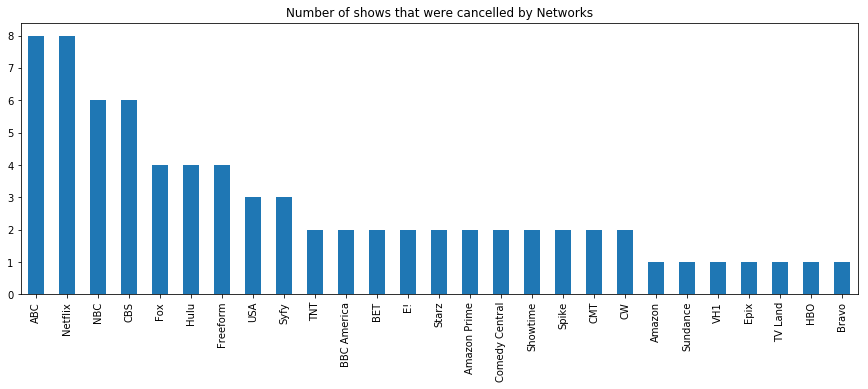

In [560]:
plt.figure(figsize=(15,5))
plt.title('Number of shows that were cancelled by Networks')
canceled['tv_network'].value_counts().plot(kind='bar')

##### Which TV networks have the most renewals?

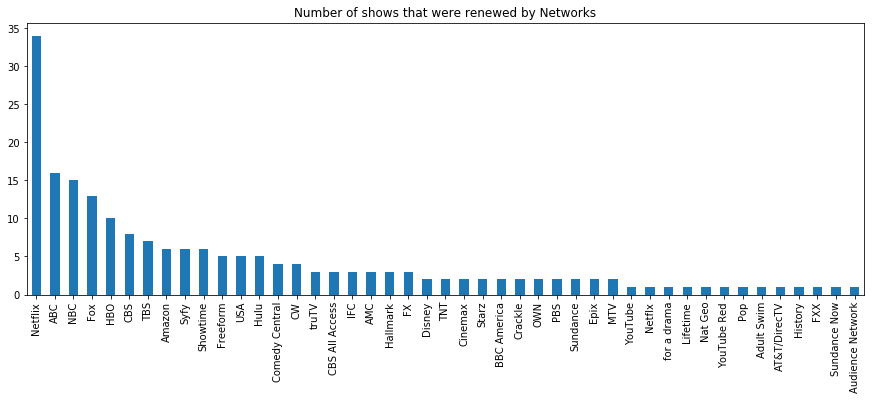

In [559]:
plt.figure(figsize=(15,5))
plt.title('Number of shows that were renewed by Networks')
renewed['tv_network'].value_counts().plot(kind='bar')

##### What is the total number of twitter followers for all of a networks of renewed shows 

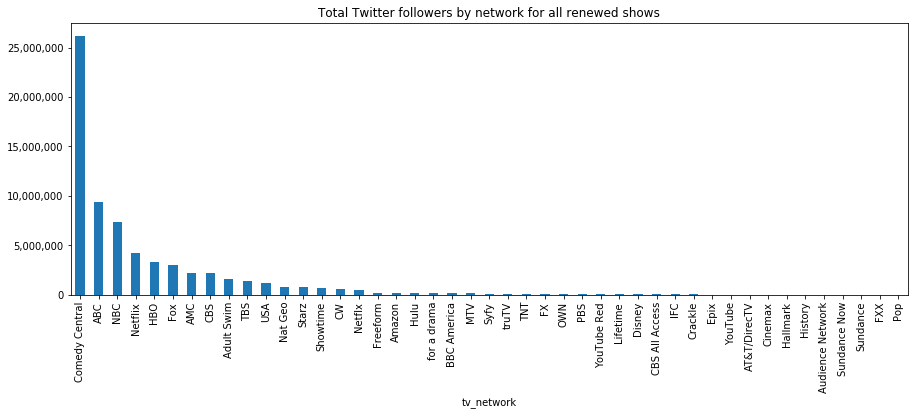

In [556]:
ax = renewed.groupby('tv_network')['twitter_followers'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))
ax.set_title("Total Twitter followers by network for all renewed shows")

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


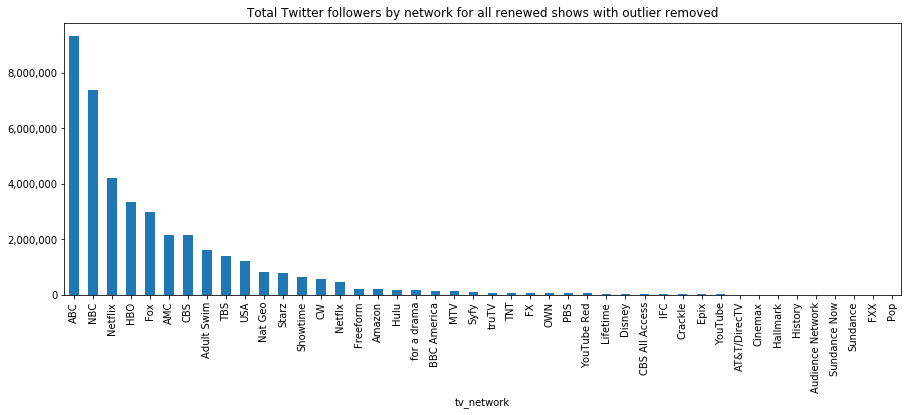

In [558]:
test = renewed.groupby('tv_network')['twitter_followers'].sum().sort_values(ascending=False)

ax = test.drop(labels=['Comedy Central']).plot(kind='bar', figsize=(15, 5))
ax.set_title("Total Twitter followers by network for all renewed shows with outlier removed")

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [518]:
renewed[(renewed['tv_network']=='Comedy Central') & (renewed['twitter_followers']>=500000)]

,tv_show_name,tv_network,imdb_score,imdb_score_num_users,avg_review_score,pos_review_sent,neg_review_sent,neut_review_sent,pos_revTitle_sent,neg_revTitle_sent,...,twitter_followers,twitter_screenname,top_rated_rank,genres,story_keywords,runtime,tv_rating,release_date,country,langauge
22,Tosh.0,Comedy Central,7.3,13890,3.9,36,15,10,36,15,...,26064235.0,danieltosh,NaN,[Comedy],"[pixelated nudity, vomiting, 2000s, 2010s, ref...",00:30:00,TV-14,2009-06-04,[USA],[English]


In [471]:
renewed[(renewed['tv_network']=='ABC') & (renewed['twitter_followers']>=500000)]

,tv_show_name,tv_network,imdb_score,imdb_score_num_users,avg_review_score,pos_review_sent,neg_review_sent,neut_review_sent,pos_revTitle_sent,neg_revTitle_sent,...,twitter_followers,twitter_screenname,top_rated_rank,genres,story_keywords,runtime,tv_rating,release_date,country,langauge
24,Dancing with the Stars,ABC,4.8,8926,6.8,38,11,10,38,11,...,1064964.0,DancingABC,NaN,"[Family, Game-Show, Music, Reality-TV]","[2000s, 2010s, 21st century, weekly eliminatio...",NaT,TV-PG,2005-06-01,[USA],[English]
27,How to Get Away with Murder,ABC,8.2,103205,5.4,35,31,9,35,31,...,919151.0,HowToGetAwayABC,NaN,"[Crime, Drama, Mystery, Thriller]","[law student, gay character, legal drama, cour...",NaT,TV-14,2014-09-25,[USA],"[English, Spanish]"
57,Grey's Anatomy,ABC,7.6,210734,3.4,31,28,16,31,28,...,4690386.0,GreysABC,NaN,"[Drama, Romance]","[surgeon, hospital, lesbian, work romance, sur...",NaT,TV-14,2005-03-27,[USA],[English]
166,American Idol,ABC,4.2,20453,4.0,45,18,12,45,18,...,2038939.0,AmericanIdol,NaN,"[Game-Show, Music, Reality-TV]","[2010s, 2000s, singing contest, pop music, mus...",NaT,TV-PG,2002-06-11,[USA],[English]


This is a bit misleading as TOSH.0 is a bit of an outlier. Daniel Tosh, the host of the show, has a twitter following of 26 Million.

ABC has the next highest following with headliners like Grey's Anatomy, American Idol and How to Get Away with Murder. 

##### What is the total number of twitter followers for all of a networks of canceled shows 

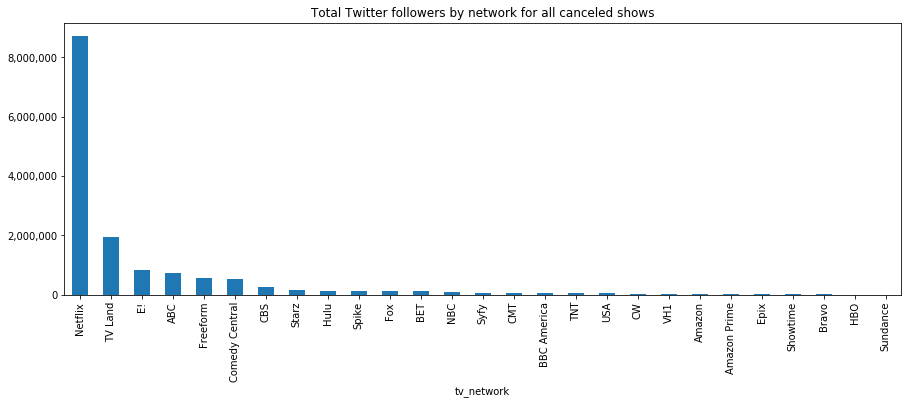

In [555]:
ax = canceled.groupby('tv_network')['twitter_followers'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))
ax.set_title("Total Twitter followers by network for all canceled shows")

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


In [480]:
canceled[(canceled['tv_network']=='Netflix') & (canceled['twitter_followers']>=100000)]

,tv_show_name,tv_network,imdb_score,imdb_score_num_users,avg_review_score,pos_review_sent,neg_review_sent,neut_review_sent,pos_revTitle_sent,neg_revTitle_sent,...,twitter_followers,twitter_screenname,top_rated_rank,genres,story_keywords,runtime,tv_rating,release_date,country,langauge
17,Sense8,Netflix,8.4,123035,5.1,35,27,13,35,27,...,338765.0,sense8,NaN,"[Drama, Mystery, Sci-Fi, Thriller]","[psychic connection, shared experiences, telep...",01:00:00,TV-MA,2015-06-05,[USA],[English]
35,Chelsea,Netflix,6.2,1778,5.2,18,15,6,18,15,...,8260297.0,chelseahandler,NaN,"[Comedy, Talk-Show]","[woman, non fiction]",NaT,TV-MA,2016-05-11,[USA],[English]


Once again, there is a bit of an outlier in the twitter following of Netflix shows. Chelsea is a show hosted by Chelsea Handler and her twitter following is 8.26 Million. The next highest twitter following is Sense8. 


##### Comparison of average twitter followers between canceled and renewed TV shows with outliers removed. 

In [568]:
renewedWithOutOutlier = test.drop(labels=['Comedy Central']).mean()
canceledWithOutlier = canceled.twitter_followers.mean()

In [573]:
print("The average number of twitter followers for renewed TV shows, with outliers removed is %s" %round(renewedWithOutOutlier, 2))

The average number of twitter followers for renewed TV shows, with outliers removed is 924488.02


In [574]:
print("The average number of twitter followers for canceled TV shows, with outliers removed is %s" %round(canceledWithOutlier, 2))

The average number of twitter followers for canceled TV shows, with outliers removed is 223346.88


It is clear to see that shows that have a higher twitter following has a higher chance of renewal. 

# Story Telling 

ABC, Netflix, NBC, CBS, and Fox have the most canceled shows

Netflix has the most renewals, followed by ABC, NBC, Fox, and HBO

* Once again, there is a bit of an outlier in the twitter following of Netflix shows. Chelsea is a show hosted by Chelsea Handler and her twitter following is 8.26 Million. The next highest twitter following is Sense8. 

* This is a bit misleading as TOSH.0 is a bit of an outlier. Daniel Tosh, the host of the show, has a twitter following of 26 Million.

ABC has the next highest following with headliners like Grey's Anatomy, American Idol and How to Get Away with Murder. 

It is clear to see that shows that have a higher twitter following has a higher chance of renewal.
